# Text Mining for DSC Segment

### Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [22]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import data file
raw=pd.read_csv("0712 DSC SEG - Copy.csv")

In [5]:
# Examine NAs
raw.isnull().sum()

Unnamed: 0                  0
loan_id                     0
charge_off_type             0
charge_off_d                0
product                     0
charge_off_gross_bal        0
charge_off_month            0
grade                       0
term                        0
three_month_repayment    1837
six_month_repayment      3932
nine_month_repayment     6192
comments                   69
numb_of_comments           65
dtype: int64

In [6]:
# Remove rows with NA in comments and prin_paid
modifiedRaw = raw.dropna(subset = ['comments', 'six_month_repayment']) 
print raw.shape[0]-modifiedRaw.shape[0], 'rows were dropped.'

3993 rows were dropped.


In [7]:
modifiedRaw.isnull().sum()

Unnamed: 0                  0
loan_id                     0
charge_off_type             0
charge_off_d                0
product                     0
charge_off_gross_bal        0
charge_off_month            0
grade                       0
term                        0
three_month_repayment       0
six_month_repayment         0
nine_month_repayment     2251
comments                    0
numb_of_comments            0
dtype: int64

In [8]:
# Add dollar percent recovered in three month, six month, nine month as attributes
modifiedRaw['percent_recovered_three_month'] = modifiedRaw['three_month_repayment']/modifiedRaw['charge_off_gross_bal']
modifiedRaw['percent_recovered_six_month'] = modifiedRaw['six_month_repayment']/modifiedRaw['charge_off_gross_bal']
modifiedRaw['percent_recovered_nine_month'] = modifiedRaw['nine_month_repayment']/modifiedRaw['charge_off_gross_bal']

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [9]:
# Selecting on prime and near prime
##prime = modifiedRaw['product'] =='Prime'
##nearprime = modifiedRaw['product'] == 'Near Prime'
##modifiedRaw = modifiedRaw[prime | nearprime]

In [10]:
# Select only observations with six_month_repayment non-negative
modifiedRaw = modifiedRaw[modifiedRaw['six_month_repayment']>-0.0001]
modifiedRaw.shape

(16117, 17)

# Descriptive Analysis

In [11]:
count_zero_repay = modifiedRaw.groupby('six_month_repayment').loan_id.count()[0]#number of loan_id having 0 paid back amount

In [14]:
float((count_zero_repay+0.00)/modifiedRaw.shape[0]) # 48% bad rate
print 'The six-month unit bad rate is', float((count_zero_repay+0.00)/modifiedRaw.shape[0])
print 'The six-month unit recovery rate is', 1 - float((count_zero_repay +0.00)/modifiedRaw.shape[0])

The six-month unit bad rate is 0.480672581746
The six-month unit recovery rate is 0.519327418254


In [15]:
a = sum(modifiedRaw['six_month_repayment'])/sum(modifiedRaw['charge_off_gross_bal']) # overall recovered dollar percentage
print'Overall six-month recovered dollar percentage is', a

Overall six-month recovered dollar percentage is 0.059683958532


In [16]:
#import matplotlib.pyplot as plt
#plt.hist(modifiedRaw['six_month_repayment'], color = 'blue', edgecolor = 'black', bins = int(11000/1), density = True)
#plt.xlim([0, 15000])
#plt.ylim([0, 0.001])

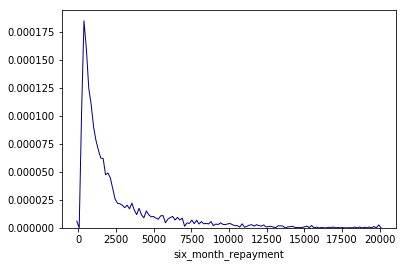

In [17]:
import seaborn as sns
# Density Plot of dollars repaid
sns.distplot(modifiedRaw['six_month_repayment'], hist=False, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

# Text Processing

In [565]:
# Process text
nltk.download('words')
from nltk.corpus import words
words = set(nltk.corpus.words.words())
def get_stemmed_text(text):
    text = text.lower() # lowercase
    text = re.sub("<!--?.*?-->","",text) # removetags
    text = re.sub("(\\d|\\W)+"," ",text) # remove special characters and digits
    text = text.replace('[^\w\s]','') # remove punctuation
    text = re.sub(" \d+", " ", text)
    stemmer = PorterStemmer() # stemming
    return stemmer.stem(text)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [566]:
modifiedRaw['comments'] = modifiedRaw['comments'].apply(lambda x:get_stemmed_text(x))

In [18]:
# See one example
modifiedRaw['comments'].iloc[100]

'"4802523662","8014626394","Called 4802523662- AP2- FV: BR was adv taht $356.28 is still due and I asked if she has a pmt in the mail to date. The BR adv that she is working with Freedom Debt Relief (916) 649-3802; 4940 S Wendler Dr #101 Tempe, AZ 85282; Agent: Ronald Combs- I advs of neg reporting thru 120 days past due and adv that we have not gotten any info/pmt from them to date. ","sip:(801)462-6394 (DNC) // SW BR (unverified), no time to speak // Asked that we not contact her at work // Updated contact info // Adv of PS phone number and office hours","4802523662","8014626394","4802523662","8014626394","Collection email sent to borrower: Account is past due","4802523662","Collection email sent to borrower: Initial payment reminder",null,"4802523662","4802523662","4802523662","(480)252-3662 BR req to opt out of ACH pmts and make check pmts - adv no billing statements she is going to set up bill pay adv $7 service fee - VCI "'

In [23]:
# remove words with no meaning
nltk.download('words')
from nltk.corpus import words
from nltk.tokenize import sent_tokenize, word_tokenize 
words = set(nltk.corpus.words.words())
def remove_nonsense_word(text):
    return " ".join(w for w in word_tokenize(text) if w in words)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [24]:
modifiedRaw['comments'] = modifiedRaw['comments'].apply(lambda x:remove_nonsense_word(x))

In [25]:
# See the example
modifiedRaw['comments'].iloc[100]

'was is still due and I if she a in the mail to date The that she is working with S Tempe Ronald I of days past due and that we have not gotten any from them to date sip unverified no time to speak that we not contact her at work contact of phone number and office sent to borrower is past due sent to borrower payment reminder null to opt out of and make check no billing she is going to set up bill pay service fee'

In [423]:
#modifiedRaw.groupby('pco_prin_paid').loan_id.count()

In [286]:
#modifiedRaw.count()

# Train and Test Split

In [26]:
# Add target
Y = 1.0 * (modifiedRaw['percent_recovered_six_month']>0)

In [27]:
X_train1, X_test1, y_train, y_test = train_test_split(modifiedRaw, Y, stratify = Y, test_size = 0.33, random_state = 42)

In [28]:
X_train = X_train1['comments']
X_test = X_test1['comments']

# Text Vecterization 

In [29]:
stop_words = set(stopwords.words('english'))

In [30]:
# remove words occuring in more than 90% of the documents
# remove words occuring less than 20 times
# remove stopwords
cv = CountVectorizer(max_df = 0.90, min_df = 20, stop_words = stop_words)
X_train_counts = cv.fit_transform(X_train)

In [31]:
#(cv.get_feature_names())
#cv.vocabulary_.get(u'portal'),cv.vocabulary_.get(u'mp'),cv.vocabulary_.get(u'looking')

(None, None, 415)

In [32]:
#print(cv.get_feature_names())

In [34]:
#list(cv.vocabulary_.keys())[11]

In [35]:
tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

In [36]:
X_test_counts = cv.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [584]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor # check for multicollinearity
#vif = [variance_inflation_factor(ddd.values, i) for i in range(ddd.shape[1])]

In [348]:
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS # stepwise selection

# Building Logistic Regression

In [39]:
# Baseline model
clf = LogisticRegression().fit(X_train_tfidf, y_train) # Lasso 

In [40]:
np.count_nonzero(clf.coef_)

841

# Hyperparameter Tuning

In [41]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [42]:
np.logspace(-10,10,15)

array([1.00000000e-10, 2.68269580e-09, 7.19685673e-08, 1.93069773e-06,
       5.17947468e-05, 1.38949549e-03, 3.72759372e-02, 1.00000000e+00,
       2.68269580e+01, 7.19685673e+02, 1.93069773e+04, 5.17947468e+05,
       1.38949549e+07, 3.72759372e+08, 1.00000000e+10])

In [43]:
lr_params = {'penalty': ['l1'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21),
            'fit_intercept':[True, False]}

In [44]:
lr_grid = GridSearchCV(clf, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

In [45]:
# fit with the tranformed sparse matrix
lr_grid = GridSearchCV(clf, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1'], 'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]), 'fit_intercept': [True, False], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [47]:
print 'Best Score:', lr_grid.best_score_

Best Score: 0.5725134284126691


In [48]:
best_lr = lr_grid.best_estimator_
print 'Best Params:', lr_grid.best_params_

Best Params: {'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear', 'fit_intercept': True}


In [49]:
clf = LogisticRegression(penalty='l1',random_state=0, C=1.0, solver =  'liblinear', n_jobs=4).fit(X_train_tfidf, y_train) # Lasso 

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [50]:
np.count_nonzero(clf.coef_)

235

## Selected Attribute/Keyword Description

In [51]:
numb_of_attribute = np.count_nonzero(clf.coef_) # number of attributes/words

In [53]:
index= np.nonzero(clf.coef_)[1]
list_of_keywords = [list(cv.vocabulary_.keys())[index[i]] for i in range(numb_of_attribute)] # keywords used in model

In [54]:
list_of_keywords

[u'reprocess',
 u'disability',
 u'applied',
 u'school',
 u'ref',
 u'even',
 u'active',
 u'hospital',
 u'program',
 u'hereby',
 u'aware',
 u'phone',
 u'give',
 u'unpaid',
 u'answer',
 u'law',
 u'appreciate',
 u'lost',
 u'think',
 u'writing',
 u'unemployed',
 u'bank',
 u'went',
 u'consolidate',
 u'financial',
 u'directly',
 u'list',
 u'message',
 u'already',
 u'electronic',
 u'confirming',
 u'incur',
 u'kept',
 u'responsible',
 u'client',
 u'saying',
 u'reschedule',
 u'reversal',
 u'report',
 u'respond',
 u'fail',
 u'subject',
 u'said',
 u'melissa',
 u'wo',
 u'debt',
 u'received',
 u'loaded',
 u'life',
 u'worked',
 u'stopping',
 u'balance',
 u'confirmed',
 u'showing',
 u'waterfall',
 u'save',
 u'possible',
 u'wanting',
 u'night',
 u'hung',
 u'afternoon',
 u'form',
 u'request',
 u'til',
 u'update',
 u'professional',
 u'weekend',
 u'permanently',
 u'item',
 u'settle',
 u'current',
 u'unsure',
 u'change',
 u'box',
 u'sending',
 u'extra',
 u'prefer',
 u'club',
 u'department',
 u'anything',
 

In [55]:
normalized_frequency = [((cv.vocabulary_.get(list_of_keywords[i]) + 0.00)/modifiedRaw.shape[0]) for i in range(numb_of_attribute)]
frequency = [cv.vocabulary_.get(list_of_keywords[i]) for i in range(numb_of_attribute)]
keywords_freq = pd.DataFrame({'keywords':list_of_keywords,
                              'normalized_frequency': normalized_frequency,
                              'frequency': frequency})
keywords_freq.sort_values('frequency',ascending=False)

,frequency,keywords,normalized_frequency
216,834,written,0.051747
19,833,writing,0.051685
49,829,worked,0.051436
44,824,wo,0.051126
231,818,wish,0.050754
133,816,wife,0.050630
22,815,went,0.050568
163,814,well,0.050506
66,812,weekend,0.050382
106,810,ways,0.050257


## Keyword Context

In [601]:
w = list_of_keywords[142]

In [602]:
keyword1 = [modifiedRaw['comments'].iloc[i].find(str(w)) for i in range(modifiedRaw.shape[0])]

In [603]:
index1 = [i for i, n in enumerate(keyword1) if n >=0]

In [604]:
modifiedRaw['comments'].iloc[index1[1]]

'phone type l old none new is collector col collector none phone returned code not contact is returned code not found standardized address s request old status act returned no request name old none new is old status old none new is request name old home was found in list added to on request name off collector new result customer hung up in out home predictive call result no answer home predictive call request name s drive request request request request is on collector scrub complete request name person said not in today result machine home predictive call a ave chino ca old status act result customer hung up in out home predictive call result machine home predictive call result machine home predictive call score result machine home predictive call collector col old status s primary result code sh best result code m address a new last old status lad old number was result fast busy s old cell number was result fast busy home predictive call result fast busy home predictive call result f

# Dimmensionality Reduction

In [140]:
from sklearn.decomposition import TruncatedSVD
# truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. 
# In that context, it is known as latent semantic analysis (LSA).

In [146]:
svd = TruncatedSVD(algorithm='randomized', n_components=50, n_iter=7,
        random_state= 42, tol=0.0)
# X_train_counts = svd.fit_transform(X_train_counts) 

# Train Set

In [56]:
train = X_train1
train['y'] = y_train

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
train['pred1']= clf.predict(X_train_tfidf)
train['proba']= clf.predict_proba(X_train_tfidf)[:,1]

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
train['pred1_right'] = 1.0 * (train['pred1']==train['y'])
train['pred1_wrong']= 1 - train['pred1_right']
print 'Percent of train set which class prediction is wrong', train.pred1_wrong.mean()

Percent of train set which class prediction is wrong 0.3904426745693647


C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Test Set

In [64]:
test = X_test1
test['y'] = y_test

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
test['pred1']= clf.predict(X_test_tfidf)
test['proba']= clf.predict_proba(X_test_tfidf)[:,1]

C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
test['pred1_right'] = 1.0 * (test['pred1']==test['y'])
test['proba']= clf.predict_proba(X_test_counts)[:,1]
test['pred1_wrong']= 1 - test['pred1_right']
print 'Percent of test set which class prediction is wrong', test.pred1_wrong.mean()

Percent of test set which class prediction is wrong 0.4357962022936642


C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jzhu\AppData\Local\Continuum\anaconda2\envs\py2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

# Model Evaluation

Precision, Recall, F1-Score

In [69]:
from sklearn.metrics import classification_report
print(classification_report(train['pred1'], train['y']))

              precision    recall  f1-score   support

         0.0       0.49      0.62      0.55      4136
         1.0       0.72      0.60      0.66      6662

   micro avg       0.61      0.61      0.61     10798
   macro avg       0.61      0.61      0.60     10798
weighted avg       0.63      0.61      0.61     10798



In [70]:
print(classification_report(test['pred1'], test['y']))

              precision    recall  f1-score   support

         0.0       0.43      0.56      0.49      1985
         1.0       0.68      0.57      0.62      3334

   micro avg       0.56      0.56      0.56      5319
   macro avg       0.56      0.56      0.55      5319
weighted avg       0.59      0.56      0.57      5319



In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [72]:
confusion_matrix(test['y'],test['pred1'])

array([[1112, 1445],
       [ 873, 1889]], dtype=int64)

In [75]:
print 'The training set accuracy is',accuracy_score(train['y'], train['pred1'], normalize = True)

The training set accuracy is 0.6095573254306353


In [76]:
print 'The testing set accuracy is',accuracy_score(test['y'], test['pred1'], normalize = True)

The testing set accuracy is 0.5642037977063358


ROC, KS

In [78]:
from sklearn.metrics import roc_curve
import sklearn.metrics as me

Text(0,0.5,'tpr')

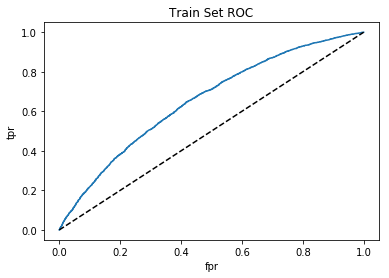

In [81]:
y_pred_prob = clf.predict_proba(X_train_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.title('Train Set ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')

In [83]:
auc = me.roc_auc_score(y_train, y_pred_prob)
print 'The train set AUC is', auc

The train set AUC is 0.6542118642786661


In [85]:
ks=max(tpr-fpr)
print 'KS score for train set is', ks

KS score for train set is 0.22994854584285046


Text(0,0.5,'tpr')

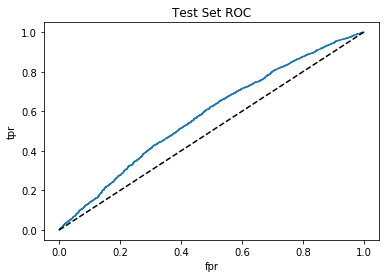

In [86]:
y_pred_proba = clf.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.title('Test Set ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')

In [87]:
auc1 = me.roc_auc_score(y_test, y_pred_proba)
print 'The test set AUC is', auc1

The test set AUC is 0.5800531374877274


In [88]:
ks=max(tpr-fpr)
print 'KS score for test set is', ks

KS score for test set is 0.12611940869111132


Recovery Count

In [89]:
train_sorted = train.sort_values(by = 'proba', ascending = False) # sort by score

In [90]:
a = train_sorted.shape[0]/10
number_list = [0,a+1,2*a+1, 3*a+1, 4*a+1, 5*a+1, 6*a+1, 7*a+1, 8*a+1]
mean = [train_sorted.iloc[i:i+a,:].y.mean() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].y.mean()
mean.append(b)
mean

[0.7210379981464319,
 0.6663577386468953,
 0.6274328081556997,
 0.5894346617238183,
 0.5421686746987951,
 0.5115848007414272,
 0.48007414272474513,
 0.43373493975903615,
 0.35588507877664505,
 0.26795580110497236]

Text(0.5,0,'Ranked Subset')

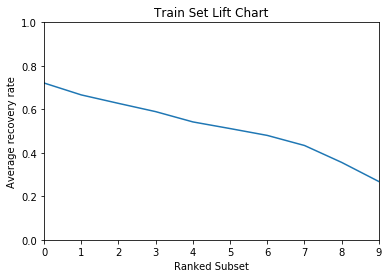

In [92]:
plt.plot(mean)
plt.axis([0,9,0,1])
plt.title('Train Set Lift Chart')
plt.ylabel('Average recovery rate')
plt.xlabel('Ranked Subset')

In [93]:
test_sorted = test.sort_values(by = 'proba', ascending = False) # sort by score

In [94]:
c = test_sorted.shape[0]/10
number_list = [0,c+1,2*c+1, 3*c+1, 4*c+1, 5*c+1, 6*c+1, 7*c+1, 8*c+1]
mean_test = [test_sorted.iloc[i:i+c,:].y.mean() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].y.mean()
mean_test.append(b)
mean_test

[0.6308851224105462,
 0.583804143126177,
 0.5725047080979284,
 0.576271186440678,
 0.5310734463276836,
 0.5291902071563088,
 0.4839924670433145,
 0.4708097928436911,
 0.4030131826741996,
 0.4137291280148423]

Text(0.5,0,'Ranked Subset')

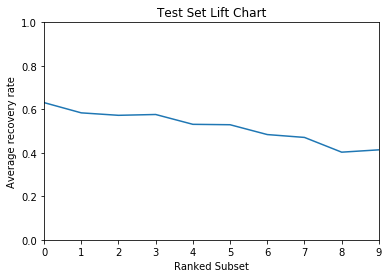

In [95]:
plt.plot(mean_test)
plt.axis([0,9,0,1])
plt.title('Test Set Lift Chart')
plt.ylabel('Average recovery rate')
plt.xlabel('Ranked Subset')

Dollar Recovery Percentage

In [96]:
a = train_sorted.shape[0]/10
number_list = [0,a+1,2*a+1, 3*a+1, 4*a+1, 5*a+1, 6*a+1, 7*a+1, 8*a+1]
sum_train = [train_sorted.iloc[i:i+a,:].six_month_repayment.sum() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].six_month_repayment.sum()
sum_train.append(b)
sum_train

sum_prin_train = [train_sorted.iloc[i:i+a,:].charge_off_gross_bal.sum() for i in number_list] #average recovery rate
b = train_sorted.iloc[9*a+1:,:].charge_off_gross_bal.sum()
sum_prin_train.append(b)
sum_prin_train

dollar_percent = [x/y for x, y in zip(sum_train,sum_prin_train)]
dollar_percent

[0.08469692543758482,
 0.07899098435385735,
 0.07049477944022516,
 0.06754751375535345,
 0.06415514110781483,
 0.054043094637561434,
 0.05700423823789642,
 0.05134921151339238,
 0.04299878674987698,
 0.024935796446246473]

Text(0.5,0,'Ranked Subset')

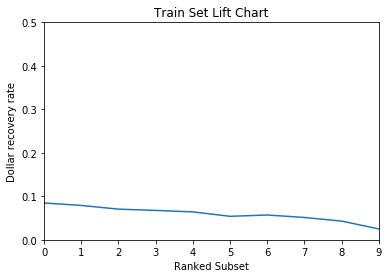

In [97]:
plt.plot(dollar_percent)
plt.axis([0,9,0,0.5])
plt.title('Train Set Lift Chart')
plt.ylabel('Dollar recovery rate')
plt.xlabel('Ranked Subset')

In [98]:
c = test_sorted.shape[0]/10
number_list = [0,c+1,2*c+1, 3*c+1, 4*c+1, 5*c+1, 6*c+1, 7*c+1, 8*c+1]
sum_test = [test_sorted.iloc[i:i+c,:].six_month_repayment.sum() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].six_month_repayment.sum()
sum_test.append(b)

In [99]:
sum_prin_test = [test_sorted.iloc[i:i+c,:].charge_off_gross_bal.sum() for i in number_list] #average recovery rate
b = test_sorted.iloc[9*c+1:,:].charge_off_gross_bal.sum()
sum_prin_test .append(b)

In [100]:
dollar_percent = [x/y for x, y in zip(sum_test,sum_prin_test)]
dollar_percent

[0.06788941652045773,
 0.06442129863480649,
 0.07026268901324317,
 0.06440293541395634,
 0.06354056578652316,
 0.07055082599439763,
 0.05566224057268863,
 0.05556729106146497,
 0.04907279357589548,
 0.044634541571184023]

Text(0.5,0,'Ranked Subset')

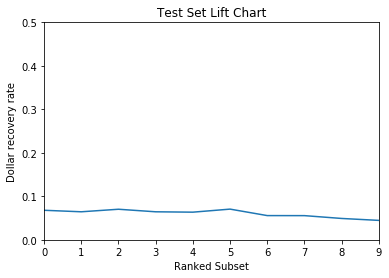

In [102]:
plt.plot(dollar_percent)
plt.axis([0,9,0,0.5])
plt.title('Test Set Lift Chart')
plt.ylabel('Dollar recovery rate')
plt.xlabel('Ranked Subset')

## Append Score

In [103]:
X_all = modifiedRaw['comments']

In [104]:
X_all_counts = cv.transform(X_all)

In [105]:
X_all_tfidf = tfidf_transformer.transform(X_all_counts)

In [106]:
modifiedRaw['score'] = clf.predict_proba(X_all_tfidf)[:,1]

## Add Behavior Score

In [111]:
bs =pd.read_csv('jzhu_DSC_seg_0712_bmerge.csv')

In [112]:
df = pd.merge(modifiedRaw, bs, on = 'loan_id', how = 'left')

In [887]:
df = df.dropna(subset = ['behavior_score']) # remove rows with NA in behavior_score

(12701, 22)

In [110]:
# Export file to use for ensembled model
df.to_csv(r'export_DSC_0719.csv', index = None, header = True)